In [1]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textstat
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In [3]:
df = pd.DataFrame(columns=['year', 'president', 'party', 'text'])

for i in range(len(dirs)):
    components = dirs[i].split('_')
    name = components[0]
    year = components[1].split('.')[0]
    df.loc[i,'year'] = year
    df.loc[i,'president'] = name   
    
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, "r")
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    df.loc[i, 'text'] = lines.lower()
    
df.year = df.year.astype(int) 
df.president = df.president.astype(str)
df.text = df.text.astype(str)
print('Shape: ', df.shape)

Shape:  (228, 4)


There are a few presidents that have the same last name (Roosevelt, Bush, Johnson and Adams), so let's clean that up now.

In [4]:
# need to distinuish between Theodore Roosevelt and Franklin D. Roosevelt
indices = df.query("president =='Roosevelt' & year <= 1909").index
df.loc[indices,'president'] = 'Theodore Roosevelt'

indices = df.query("president == 'Roosevelt'").index
df.loc[indices,'president'] = 'Franklin D. Roosevelt'

indices = df.query("president =='Bush' & year <= 1992").index
df.loc[indices,'president'] = 'George H. W. Bush'

indices = df.query("president == 'Bush'").index
df.loc[indices,'president'] = 'George W. Bush'

indices = df.query("president =='Johnson' & year <= 1869").index
df.loc[indices,'president'] = 'Andrew Johnson'

indices = df.query("president == 'Johnson'").index
df.loc[indices,'president'] = 'Lyndon B. Johnson'

indices = df.query("president =='Adams' & year <= 1801").index
df.loc[indices,'president'] = 'John Adams'

indices = df.query("president == 'Adams'").index
df.loc[indices,'president'] = 'John Quincy Adams'


indices = df.query("president =='Harrison' & year <= 1841").index
df.loc[indices,'president'] = 'William Henry Harrison'

indices = df.query("president == 'Harrison'").index
df.loc[indices,'president'] = 'Benjamin Harrison'

Now let's attach the political party to the president (note some presidents changed parties throughout their political career, I am simply listing the party they belonged to while serving as President).

In [5]:
def pres_to_party(name):
    republican = ['Lincoln', 'Grant', 'Hayes', 'Garfield', 'Arthur', 
                  'Benjamin Harrison', 'McKinley', 'Theodore Roosevelt', 
                  'Taft', 'Harding', 'Coolidge', 'Hoover', 'Eisenhower', 
                  'Nixon', 'Ford', 'Reagan', 'George H. W. Bush', 
                  'George W. Bush', 'Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Jackson', 'Buren', 'Polk', 'Pierce', 
                  'Buchanan', 'Cleveland', 'Wilson', 'Franklin D. Roosevelt', 
                  'Truman', 'Kennedy', 'Lyndon B. Johnson', 'Carter', 'Clinton', 'Obama']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Taylor', 'Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['Washington', 'Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Jefferson', 'Madison', 'Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'

In [6]:
df.party = df.president.apply(pres_to_party)

df.set_index('year', inplace=True)
df.sort_index(inplace=True)
df.head()

,president,party,text
year,,,
1790,Washington,Unaffiliated,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [7]:
# need to drop George Washington's 1790 address as the file is empty
df = df.iloc[1:,:]
df.head()

,president,party,text
year,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [10]:
df.groupby('party').size()

party
Democratic               88
Democratic-Republican    28
Federalist                4
National Union            4
Republican               89
Unaffiliated             10
Whig                      4
dtype: int64

In [11]:
import re
from gensim import models, corpora
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
NUM_TOPICS = 10
STOPWORDS = stopwords.words('english')

In [13]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

In [14]:
df['tokens'] = df.text.apply(clean_text)

In [16]:
df.head()

,president,party,text,tokens
year,,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."


# Topic Modeling

In [95]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df.tokens)

dictionary.filter_extremes(no_above=.3)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df.tokens]

In [96]:
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, 
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

In [97]:
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, 
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

In [98]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
    
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
    
print("=" * 20)

LDA Model:
Topic #0: 0.004*"tonight" + 0.003*"gold" + 0.002*"silver" + 0.002*"percent" + 0.002*"inflation" + 0.002*"nuclear" + 0.002*"spending" + 0.002*"chinese" + 0.001*"oil" + 0.001*"mexican"
Topic #1: 0.002*"texas" + 0.002*"tonight" + 0.002*"mexican" + 0.002*"silver" + 0.001*"gold" + 0.001*"inflation" + 0.001*"postal" + 0.001*"spanish" + 0.001*"bureau" + 0.001*"housing"
Topic #2: 0.004*"tonight" + 0.003*"percent" + 0.002*"gold" + 0.002*"silver" + 0.002*"democracy" + 0.002*"soviet" + 0.002*"nuclear" + 0.001*"commitment" + 0.001*"parent" + 0.001*"route"
Topic #3: 0.004*"tonight" + 0.003*"percent" + 0.002*"housing" + 0.002*"veteran" + 0.002*"gold" + 0.002*"nuclear" + 0.002*"spending" + 0.002*"big" + 0.002*"democracy" + 0.002*"bureau"
Topic #4: 0.004*"tonight" + 0.002*"nuclear" + 0.002*"texas" + 0.002*"democracy" + 0.002*"gold" + 0.002*"percent" + 0.002*"soviet" + 0.002*"silver" + 0.002*"circulation" + 0.001*"student"
Topic #5: 0.002*"tonight" + 0.002*"gold" + 0.002*"mexican" + 0.002*"p

Now that we have extracted the top 10 most likely topics, we can apply them to each address separately.

In [99]:
lsi_scores = [] # np.array((len(corpus), NUM_TOPICS))
lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    x = lsi_model[corpus[i]]
    #lsi_scores.append([score[1] for score in x])
    lsi_scores.append({score[0]:score[1] for score in x})
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})
    
lsi_df = pd.DataFrame(lsi_scores)
lsi_df.index = df.index

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df.index
lda_df.fillna(0.0, inplace=True)
lsi_df.fillna(0.0, inplace=True)

lda_df.head()

,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
1791,0.0,0.000000,0.443610,0.0,0.0,0.012405,0.0,0.000000,0.541207,0.000000
1792,0.0,0.000000,0.000000,0.0,0.0,0.436354,0.0,0.000000,0.000000,0.556028
1793,0.0,0.014894,0.484682,0.0,0.0,0.000000,0.0,0.466078,0.031404,0.000000
1794,0.0,0.000000,0.609771,0.0,0.0,0.125980,0.0,0.211649,0.000000,0.048085
1795,0.0,0.000000,0.641637,0.0,0.0,0.355261,0.0,0.000000,0.000000,0.000000


Attach political party to lsi_scores to see if there is any major differences between the political parties.

In [100]:
lda_df['party'] = df.party
lda_df.groupby('party').mean()

,0,1,2,3,4,5,6,7,8,9
party,,,,,,,,,,
Democratic,0.036256,0.197816,0.146944,0.199317,0.003437,0.072019,0.107821,0.087404,0.133581,0.010979
Democratic-Republican,0.041759,0.222572,0.305335,0.000000,0.000925,0.223348,0.005212,0.056869,0.035702,0.104110
Federalist,0.000000,0.000000,0.000000,0.248880,0.000000,0.000000,0.725423,0.000000,0.000000,0.020082
National Union,0.133453,0.113340,0.057002,0.000000,0.000000,0.220246,0.000000,0.151528,0.107877,0.211634
Republican,0.058474,0.086753,0.166391,0.191574,0.026357,0.164464,0.077382,0.072089,0.095051,0.057083
Unaffiliated,0.033557,0.226442,0.390821,0.000000,0.000000,0.119722,0.000000,0.104554,0.057261,0.060411
Whig,0.054866,0.286545,0.041120,0.000000,0.000000,0.488302,0.000000,0.020736,0.067283,0.032778


In [23]:
lsi_df.head()

,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
1791,37.018155,-13.170762,0.541355,4.001293,0.740446,4.683030,5.192985,2.707593,0.659560,2.205371
1792,30.615200,-9.250015,-2.548476,-0.677888,0.535422,3.334613,5.227256,-0.979047,4.225668,1.733581
1793,33.344801,-11.733792,3.394773,9.052870,-0.744196,6.267745,-4.019663,6.159126,0.773303,4.455664
1794,41.060863,-13.737188,-2.053167,6.133913,-0.258056,7.741288,-1.044790,7.719725,-0.812965,2.595824
1795,26.460758,-8.337212,-0.640948,1.861252,-0.317468,4.389004,4.082823,-0.531725,1.598623,-1.371134


In [101]:
lsi_df['party'] = df.party
lsi_df.groupby('party').mean()

,0,1,2,3,4,5,6,7,8,9
party,,,,,,,,,,
Democratic,16.388994,2.640939,4.301971,-0.306087,-3.996173,1.992414,1.342172,1.353998,0.972896,0.016181
Democratic-Republican,5.434992,-2.594778,1.834608,-1.566771,-0.030823,0.263194,3.942932,1.299625,-0.220646,0.102008
Federalist,2.436426,-1.336215,0.813401,-0.379848,-0.133130,-0.020065,1.726205,0.231810,-0.472708,0.064283
National Union,16.913304,-8.945701,4.953797,3.742787,-0.632748,0.724687,5.488271,4.201612,2.703813,2.612929
Republican,17.742174,0.294771,-3.165333,-0.029062,-2.743302,0.325315,0.659128,-1.138874,-0.876089,0.591159
Unaffiliated,7.737087,-4.275878,4.485869,-1.491923,-0.160234,0.188512,1.221797,2.196144,1.402640,1.024188
Whig,16.997047,-8.864277,7.764248,-7.330410,0.145066,-0.199065,6.944707,2.596966,1.902765,-0.059153


So topic scores should really help our classification model!

<Figure size 1440x504 with 0 Axes>

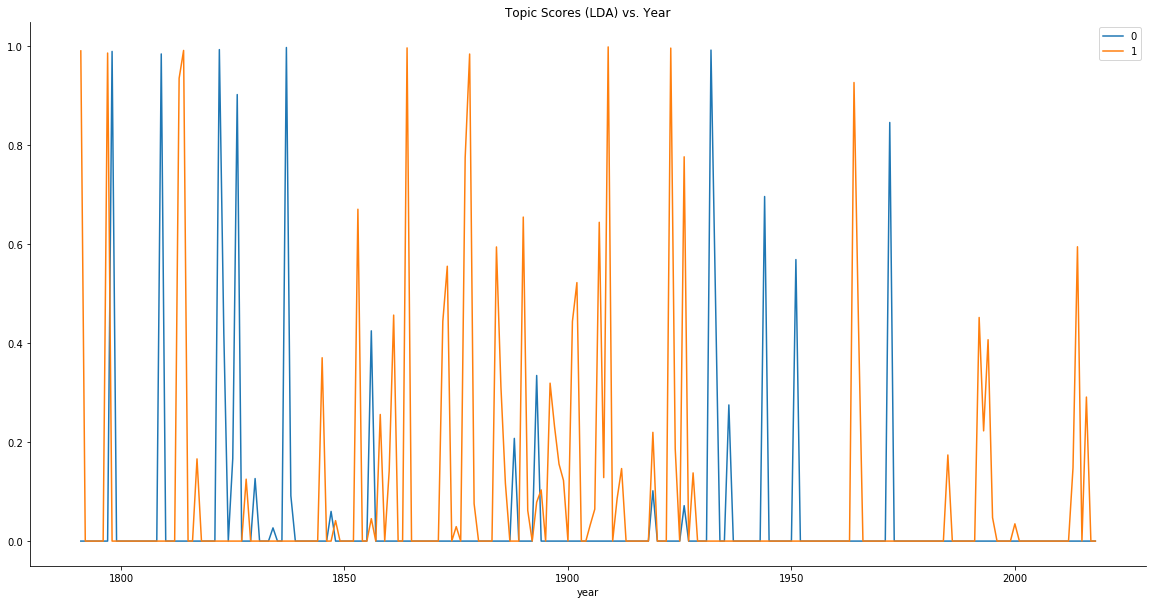

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(20,7))
lda_df.iloc[:,:2].plot.line()
plt.title('Topic Scores (LDA) vs. Year')
sns.despine()
plt.gcf().set_size_inches(20, 10)
plt.savefig('topics_1_2_lda.png')
plt.show()
plt.clf()

<Figure size 1440x720 with 0 Axes>

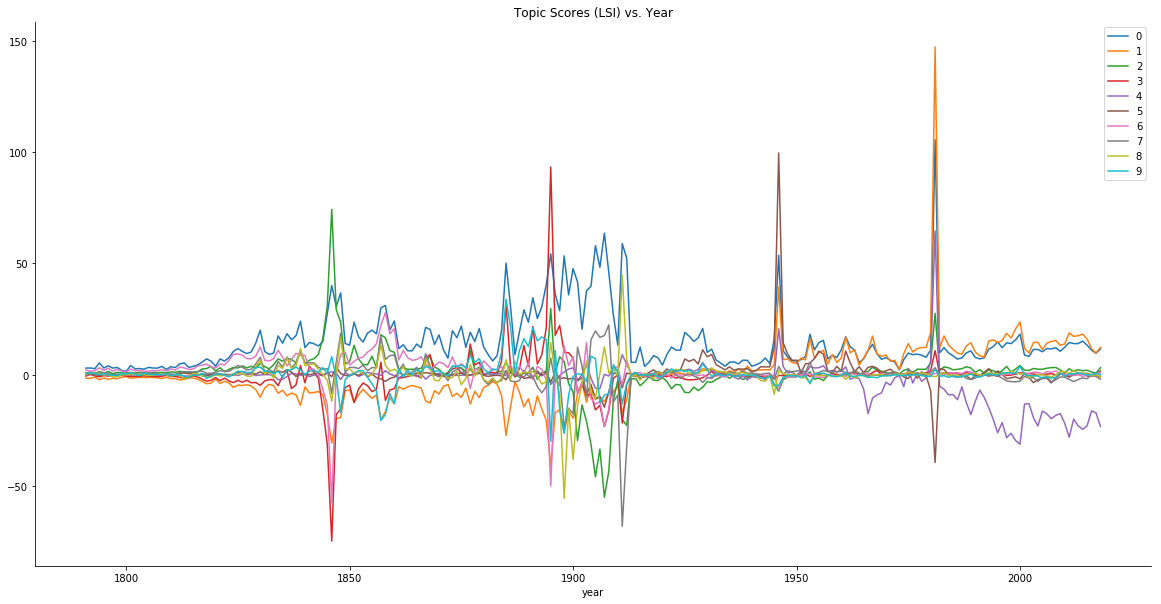

<Figure size 432x288 with 0 Axes>

In [102]:
plt.figure(figsize=(20,10))
lsi_df.drop('party', axis=1).plot.line()
plt.title('Topic Scores (LSI) vs. Year')
sns.despine()
plt.gcf().set_size_inches(20, 10)
plt.savefig('topics_lsi.png')
plt.show()
plt.clf()

Topic #0: 0.306*"state" + 0.276*"government" + 0.204*"year" + 0.189*"make" + 0.165*"congress" + 0.150*"country" + 0.145*"upon" + 0.143*"united" + 0.132*"great" + 0.132*"would"  

We can filter out terms that dominate the speeches in an effort to uncover "more" latent topics.

Regardless of what I set no_above to (for excluding terms that appear very often), I still see peaks (both positive and negative) around the same times, what I imagine to be around 1960 and 1980. I observed more 'peaks' prior to 1830, however the magnitude of the difference in peak high and low are much smaller. These topics appear to be decreasing in strength since the millennium. 

Now let's download and clean Trump's 2019 SOTU address and see what the strength of these inferred topics are.

# Classification  

For this project I will be building a model to accurately classify political party. I manually curated this information to match up with the order the files were read in (in dirs variable).

In [103]:
tokenized_docs = []
for tokens in df.tokens:
    ts = ' '.join(tokens)
    tokenized_docs.append(ts)

In [104]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(stop_words='english', max_df=.3)
bow = cv.fit_transform(tokenized_docs).toarray()

In [105]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(bow, 
                                                    df.party, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [106]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
print('Training score: ',sgd.score(X_train, y_train))
y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred))

Training score:  1.0
                       precision    recall  f1-score   support

           Democratic       0.81      0.68      0.74        19
Democratic-Republican       1.00      1.00      1.00         6
           Federalist       1.00      1.00      1.00         1
       National Union       1.00      1.00      1.00         1
           Republican       0.76      0.84      0.80        19
         Unaffiliated       0.00      0.00      0.00         0

            micro avg       0.80      0.80      0.80        46
            macro avg       0.76      0.75      0.76        46
         weighted avg       0.82      0.80      0.81        46



There is definitely a class imbalance here, so what if we are only interested in classifying them as republican, democratic or other?  

Now let's add the topic scores and see how that impacts our model.

In [107]:
X_lsi = np.concatenate((bow, lsi_df.drop('party', axis=1).values), axis=1)

In [108]:
X_lsi_train, X_lsi_test, y_lsi_train, y_lsi_test = train_test_split(X_lsi, 
                                                    df.party, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [109]:
sgd_lsi = SGDClassifier()
sgd_lsi.fit(X_lsi_train, y_lsi_train)
print('Training score: ',sgd_lsi.score(X_lsi_train, y_train))
y_pred_lsi = sgd_lsi.predict(X_lsi_test)
print(classification_report(y_lsi_test, y_pred_lsi))

Training score:  1.0
                       precision    recall  f1-score   support

           Democratic       0.93      0.68      0.79        19
Democratic-Republican       1.00      1.00      1.00         6
           Federalist       1.00      1.00      1.00         1
       National Union       0.00      0.00      0.00         1
           Republican       0.72      0.95      0.82        19

            micro avg       0.83      0.83      0.83        46
            macro avg       0.73      0.73      0.72        46
         weighted avg       0.83      0.83      0.82        46



So with the right filtering of commonly used terms (like great or America), we were able to improve the accuracy of our classification model! Next let's use word2vec embeddings instead of just bag of words.  

**ROC curve would be nice.**

## word2vec

In [110]:
from gensim.models import Word2Vec
model_sotu = Word2Vec(sentences=df.tokens, 
                      size=100, 
                      window=5, 
                      min_count=5, 
                      workers=4, 
                      sg=0)